# Preliminary Investigation of New York Police Department Citizen Complaints

By Ashok Khosla

From the github website of the New York Civil Liberties Union:

>NYPD Misconduct Complaint Database – 08.20.20

>ccrb_database_raw.xlsx is a record of the complaints made by the public to the Civilian Complaint Review Board (CCRB). These complaints span two distinct periods: the time since the CCRB started operating as an independent city agency outside the NYPD in 1994 and the prior period when the CCRB operated within the NYPD. The data includes 323,911 unique complaint records involving 81,550 active or former NYPD officers. The data does not include complaints for which the CCRB has not completed an investigation as of July 2020. For more information, please visit [nyclu.org/nypdrecords](nyclu.org/nypdrecords)

In [17]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import time
import itertools
import random
import os


#Graphics Library settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.express as px

#IPython/Jupyter settings
from IPython import get_ipython
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
np.set_printoptions(precision=4, suppress=True)
fig=plt.figure(figsize=(20, 10), dpi= 300, facecolor='w', edgecolor='k')

show_qGrid = False
if show_qGrid:
    import qgrid
    qgrid.set_grid_option('filterable', False)
def display_dataframe(adataframe):
    if show_qGrid:
        qgrid_widget = qgrid.show_grid(adataframe, show_toolbar=False)
        return qgrid_widget
    else:
        return adataframe

# Economist style...
def set_economist_style():
    params = {"figure.facecolor": "#cad9e1",
              "axes.facecolor": "#cad9e1",
              "axes.grid" : True,
              "axes.grid.axis" : "y",
              "grid.color"    : "#ffffff",
              "grid.linewidth": .75,
              "grid.linestyle": 'dotted',
              "axes.spines.left" : False,
              "axes.spines.right" : False,
              "axes.spines.top" : False,
              "ytick.major.size": 0,
              "ytick.minor.size": 0,
              "xtick.direction" : "in",
              "xtick.major.size" : 7,
              "xtick.color"      : "#191919",
              "axes.edgecolor"    :"#191919",
              "axes.prop_cycle" : plt.cycler('color',
                          ['#006767', '#ff7f0e', '#2ca02c', '#d62728',
                           '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                           '#bcbd22', '#17becf'])
              }
    plt.rcParams.update(params)
    mpl.rcParams['font.family'] = 'sans-serif'
    mpl.rcParams['font.sans-serif'] = ['Lucida Grande', 'Tahoma', 'Monaco']
    mpl.rcParams['figure.dpi']= 120
    mpl.rcParams['axes.axisbelow'] = True
set_economist_style()
    
def prep_plot(aPlotHeight = 5):
    set_economist_style()
    plt.figure(figsize=(14, aPlotHeight))
    plt.grid(linestyle='dotted', linewidth=.75, axis='y')

<Figure size 6000x3000 with 0 Axes>

First let's look at the raw file:

In [18]:
complaints_raw_df = pd.read_csv("../data/CCRB_database_raw.csv") 
display_dataframe(complaints_raw_df)

,AsOfDate,Unique Id,First Name,Last Name,Rank,Command,ShieldNo,Complaint Id,Incident Date,FADO Type,Allegation,Board Disposition,NYPDDisposition,PenaltyDesc
0,7/14/2020,43921,Richard,Aalbue,POM,H BKLYN,3619,6290465.0,NaN,Force,Force,Unsubstantiated,NaN,NaN
1,7/14/2020,52580,Walter,Aanonsen,LT,MOUNTED,0,8300607.0,NaN,Force,Force,Complainant Unavailable,NaN,NaN
2,7/14/2020,52580,Walter,Aanonsen,LT,MOUNTED,0,8800504.0,2/15/1988,Force,Beat,Unsubstantiated,NaN,NaN
3,7/14/2020,52580,Walter,Aanonsen,LT,MOUNTED,0,9201176.0,4/2/1992,Abuse of Authority,Vehicle Searched,Unsubstantiated,NaN,NaN
4,7/14/2020,52580,Walter,Aanonsen,LT,MOUNTED,0,9201176.0,4/2/1992,Discourtesy,Nasty Words,Unsubstantiated,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323906,7/14/2020,77970,Paul,Zygas,POM,TB DT32,18838,NaN,NaN,NaN,NaN,NaN,NaN,NaN
323907,7/14/2020,61975,Mitchell,Zykofsky,SGT,PBMS,661,9200164.0,1/16/1992,Discourtesy,Nasty Words,Complaint Withdrawn,NaN,NaN
323908,7/14/2020,13114,Luke,Zylstra,POM,052 PCT,7073,NaN,NaN,NaN,NaN,NaN,NaN,NaN
323909,7/14/2020,47743,Richard,Zyta,DT2,I.A.B.,4990,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There's a lot of duplication (86%)! Let's remove the not so unique Unique ID, and then create a unique name based on shield_number, last name, first name

In [19]:
def to_clean_column_name(val): return val.strip().lower().replace(" ", "_")

complaints_raw_df.sort_values('Unique Id', inplace=True)
complaints_raw_df.drop_duplicates(subset='Unique Id', keep = False, inplace = True)
complaints_df = complaints_raw_df.rename(columns=to_clean_column_name)

complaints_df.insert(4, 'unique_name', complaints_df.shieldno + "_" + complaints_df.last_name + "_" + complaints_df.first_name)
display_dataframe(complaints_df)

,asofdate,unique_id,first_name,last_name,unique_name,rank,command,shieldno,complaint_id,incident_date,fado_type,allegation,board_disposition,nypddisposition,penaltydesc
52128,7/14/2020,9,Eduardo,Cirilo,2516_Cirilo_Eduardo,DT3,001 DET,2516,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61971,7/14/2020,11,Anthony,Cozzi,1612_Cozzi_Anthony,DT3,001 DET,1612,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95207,7/14/2020,17,Frank,Felicetti,1194_Felicetti_Frank,DT3,001 DET,1194,8703864.0,10/2/1987,Force,Punch/Kick,Substantiated (Charges),NaN,NaN
104861,7/14/2020,19,Brian,Fullam,1166_Fullam_Brian,DT3,001 DET,1166,8400941.0,NaN,Abuse of Authority,Abuse of Authority,Officer(s) Unidentified,NaN,NaN
110581,7/14/2020,20,Steven,George,5331_George_Steven,DT3,001 DET,5331,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288749,7/14/2020,81543,Gerard,Sullivan,20377_Sullivan_Gerard,POM,YTH SS,20377,NaN,NaN,NaN,NaN,NaN,NaN,NaN
292360,7/14/2020,81544,Denise,Taylor,14176_Taylor_Denise,POF,YTH SS,14176,NaN,NaN,NaN,NaN,NaN,NaN,NaN
292211,7/14/2020,81545,Todd,Taylor,6401_Taylor_Todd,DTS,YTH SS,6401,NaN,NaN,NaN,NaN,NaN,NaN,NaN
299659,7/14/2020,81548,Brian,Tuitt,4266_Tuitt_Brian,DTS,YTH SS,4266,NaN,NaN,NaN,NaN,NaN,NaN,NaN


A lot of the fields are missing (nan). Let's see how much. 

In [20]:
review_columns = ['unique_name', 'rank', 'command', 'complaint_id', 'incident_date', 'fado_type', 'allegation',  'board_disposition', 'nypddisposition', 'penaltydesc']
for column in review_columns[1:]:
    num_missing = complaints_df[column].isna().sum()
    percent_missing = round(100*num_missing/complaints_df.shape[0])
    print(f"{column} has {num_missing} missing fields (about {percent_missing}%)")
print(f"\n{complaints_df.shape[0]} total records")    

rank has 1 missing fields (about 0.0%)
command has 1 missing fields (about 0.0%)
complaint_id has 33262 missing fields (about 76.0%)
incident_date has 34420 missing fields (about 78.0%)
fado_type has 33262 missing fields (about 76.0%)
allegation has 33291 missing fields (about 76.0%)
board_disposition has 33263 missing fields (about 76.0%)
nypddisposition has 43788 missing fields (about 99.0%)
penaltydesc has 43808 missing fields (about 99.0%)

44034 total records


We can see that graphically where black indicates an entry has been filled out (although even then it's often suspect... - i.e. 3 people have shieldno 9999, and 2 have shieldno 9998

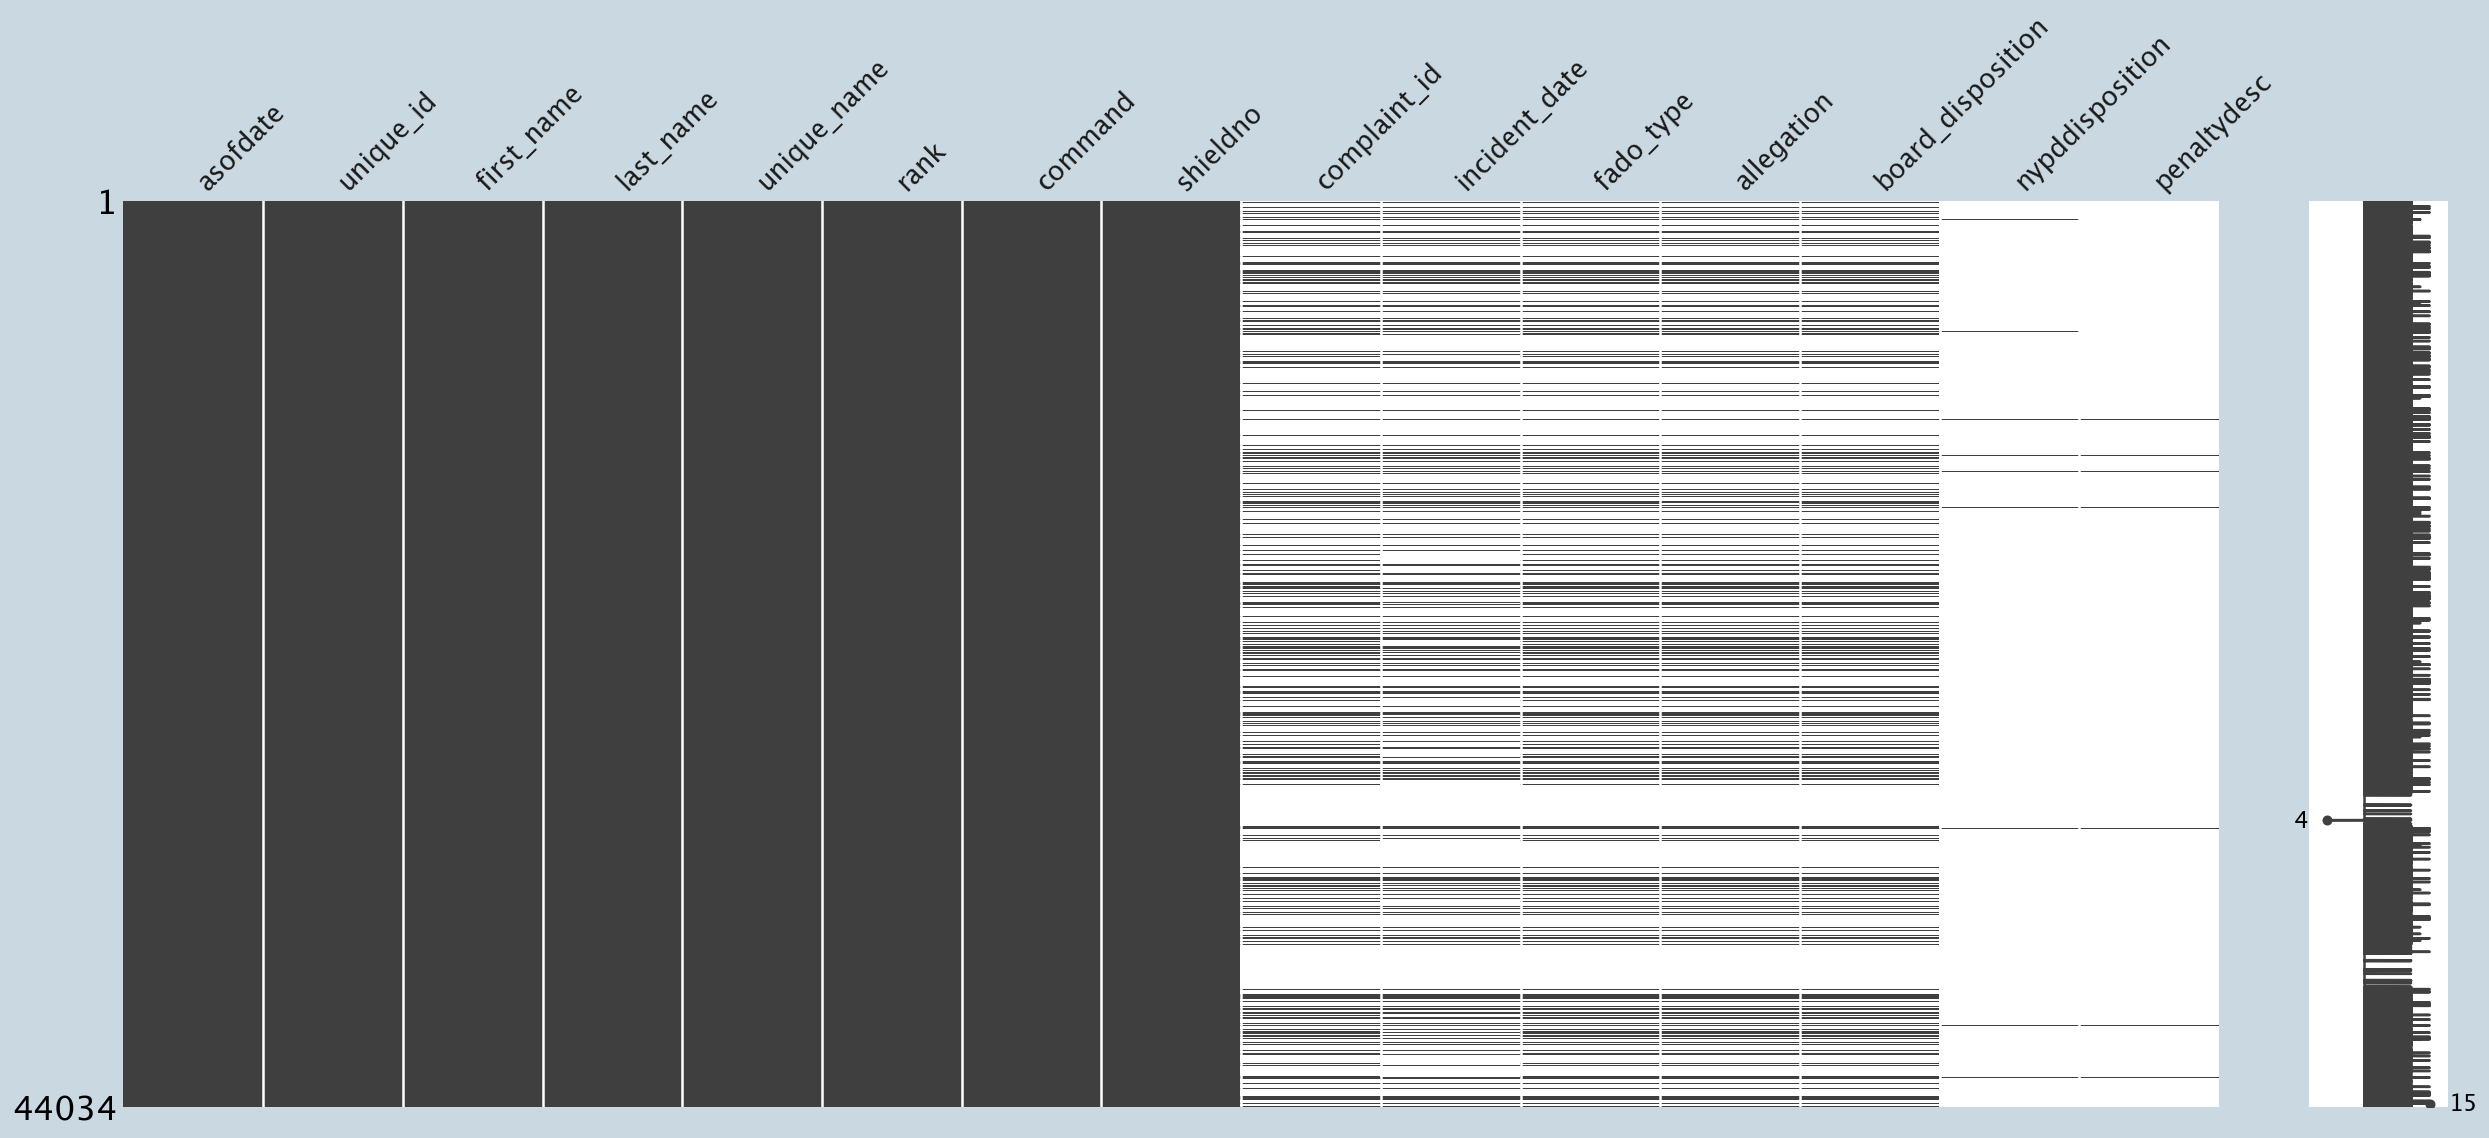

In [21]:
import missingno as msno
msno.matrix(complaints_df) 

Let's review how much rank, etc. distributes out in the database

In [22]:
review_columns = ['unique_name', 'shieldno', 'rank', 'command', 'incident_date', 'fado_type', 'allegation',  'board_disposition', 'nypddisposition', 'penaltydesc']
for column in review_columns[0:]:
    print(f"\n==================\n{column}\n==================\n")
    print(complaints_df[column].value_counts())
    


unique_name

20268_Duprey_Juan         2
3667_Mcmanus_Thomas       2
0_Jimenez_Roberto         2
5183_Gusenfitter_Scott    2
0_Aquino_Pedro            2
                         ..
13795_Driscoll_Jason      1
6726_Fulco_Ronald         1
0_Vanmanen_Jessica        1
2433_Morales_Richard      1
27165_Vicente_John        1
Name: unique_name, Length: 43884, dtype: int64

shieldno

0        3497
           39
           17
4409        8
825         8
         ... 
16931       1
5408        1
21764       1
14133       1
29486       1
Name: shieldno, Length: 23489, dtype: int64

rank

POM    24427
POF     7567
SGT     3416
DT3     2864
DT2     1165
DTS      941
LT       728
LT       684
DT1      516
CPT      377
SSA      299
SDS      280
LSA      172
LCD      139
INS      115
DI        74
DI        67
SRG       50
PSA       48
DC        25
DC        25
AC        15
AC        11
DCS        8
COP        4
CPB        3
CMA        2
CD         2
COD        1
CCA        1
COT        1
ASC        1